In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import functools

from itertools import combinations
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from torch.distributions.categorical import Categorical

device = torch.device("cpu")
plt.rcParams['mathtext.fontset'] = 'stix'


### Full length AIB9 trajectory at 500K (4M) without discretization

In [2]:
infile = '../../DATA/Train/AIB9/sum_phi_200ns.npy'
input_x = np.load(infile)

In [3]:
bins=np.arange(-15., 17, 1)
num_bins=len(bins)
idx_100ns=np.digitize(input_x, bins)

di=1
N_mean_100ns=np.sum(np.abs(idx_100ns[:-di]-idx_100ns[di:])==1)
N_mean_100ns/=len(idx_100ns)
N_mean_100ns

0.39906640023339995

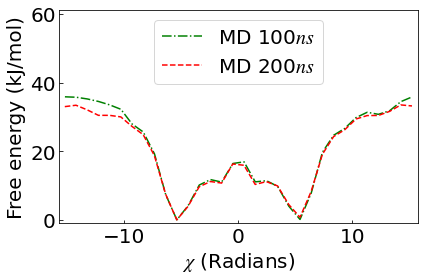

In [4]:
# data
T = 500 # unit: K
beta = 1000/(T*8.28) # kT=(8.28/1000)*T (kJ/mol/K)

hist_200ns = np.histogram(input_x, bins=32)
prob_200ns = hist_200ns[0].T/np.sum(hist_200ns[0].T)
freeE_200ns = (-1/beta)*np.log(prob_200ns-1e-11)
mids_200ns = 0.5*(hist_200ns[1][1:]+hist_200ns[1][:-1])

hist_100ns = np.histogram(input_x[:2000000], bins=32)
prob_100ns = hist_100ns[0].T/np.sum(hist_100ns[0].T)
freeE_100ns = (-1/beta)*np.log(prob_100ns-1e-11)
mids_100ns = 0.5*(hist_100ns[1][1:]+hist_100ns[1][:-1])

# plotting
fig, ax=plt.subplots(figsize=(6,4), nrows=1, ncols=1)

ax.plot(mids_100ns, freeE_100ns-np.min(freeE_100ns), linestyle='-.', color='green', label='MD 100$ns$')
ax.plot(mids_200ns, freeE_200ns-np.min(freeE_200ns), linestyle='--', color='red', label='MD 200$ns$')

ax.tick_params(axis='both', which='both', labelsize=20, direction='in')
ax.set_xlabel('$\chi$ (Radians)', size=20)
ax.set_ylabel('Free energy (kJ/mol)', size=20)
ax.set_xlim(-np.pi*5, np.pi*5)
ax.set_ylim(-1, 61)
ax.legend(loc='upper center', fontsize=20)

fig.tight_layout()
plt.savefig('input.pdf', format='pdf', dpi=300, pad_inches = 0.05)
plt.show()

### Discretizing 4M trajectory

In [5]:
bins=np.arange(-15., 17, 1)
num_bins=len(bins)
idx_input_x=np.digitize(input_x, bins)

### Longer prediction using second training

In [6]:
pred2=[]
for i in range(10):
    pdfile = './N_mean0_42/Output-conc2/{}/prediction.npy'.format(i)
    prediction2 = np.load(pdfile)
    pred2.append(prediction2)
    

### Longer prediction using first training

In [7]:
pred1={}
for i in range(10):
    pdfile = './Output-long/{}/prediction.npy'.format(i)
    prediction1 = np.load(pdfile)
    pred1[i]=prediction1

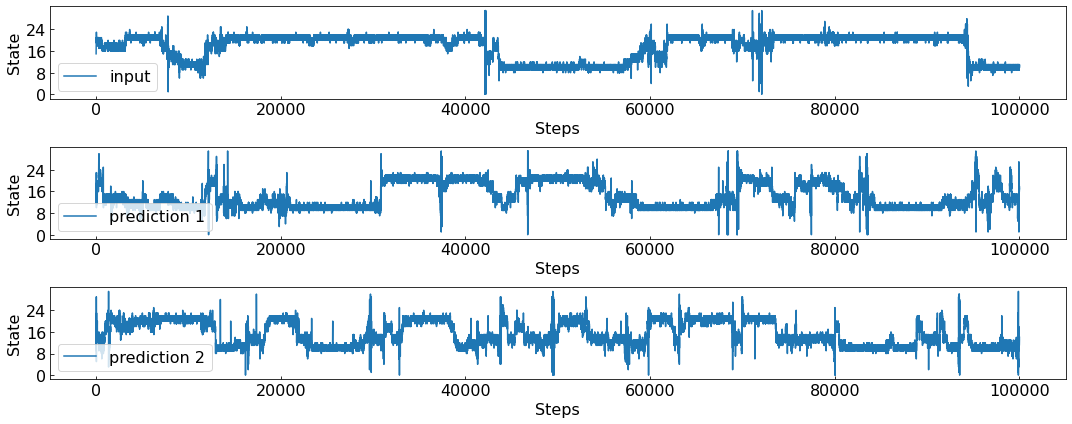

In [8]:
fig, ax = plt.subplots(figsize=(15,2*3), nrows=3, ncols=1)

ax[0].plot(idx_input_x[:100000], label='input')
ax[0].tick_params(axis='both', which='both', direction='in', labelsize=16)
ax[0].set_yticks(np.arange(0,32,8))
ax[0].set_xlabel('Steps', size=16)
ax[0].set_ylabel('State', size=16)
ax[0].legend(fontsize=16)

for i in range(2):
    ax[i+1].plot(pred2[i][:100000], label='prediction {}'.format(i+1))
    ax[i+1].tick_params(axis='both', which='both', direction='in', labelsize=16)
    ax[i+1].set_yticks(np.arange(0,32,8))
    ax[i+1].set_xlabel('Steps', size=16)
    ax[i+1].set_ylabel('State', size=16)
    ax[i+1].legend(loc='lower left', fontsize=16)

fig.tight_layout()
plt.show()

### Eigenspectrum

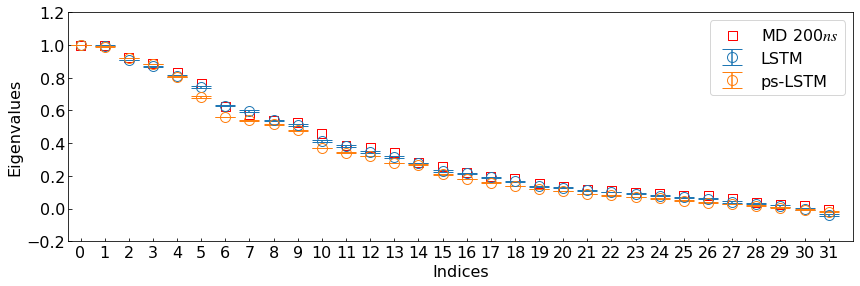

In [9]:
def eigendecompose(transmat):
    
    eigenValues, eigenVectors = np.linalg.eig(transmat)
    idx = eigenValues.real.argsort()[::-1]               # Sorting by eigenvalues
    eigenValues = eigenValues[idx]                       # Order eigenvalues
    eigenVectors = eigenVectors[:,idx]                   # Order eigenvectors
    
    return eigenValues.real, eigenVectors.real

# Input
hist_x = np.histogram2d(input_x[:-1], input_x[1:], bins=32) # (old, new)
trans_pi = hist_x[0]/hist_x[0].sum(axis=1, keepdims=True)

eval_pi, evec_pi = eigendecompose(trans_pi)

# After second training
eval_p2_arr=[]
for i in range(10):
    hist_p2 = np.histogram2d(pred2[i][:-1], pred2[i][1:], bins=32) # (old, new)
    trans_pp2 = hist_p2[0]/hist_p2[0].sum(axis=1, keepdims=True)

    eval_pp2, evec_pp2 = eigendecompose(trans_pp2)
    
    eval_p2_arr.append(eval_pp2)

mean_eval_p2, stdv_eval_p2 = np.mean(eval_p2_arr, axis=0), np.std(eval_p2_arr, axis=0)/np.sqrt(10)

# After first training
eval_p1_arr=[]
for i in range(10):
    hist_p1 = np.histogram2d(pred1[i][:-1], pred1[i][1:], bins=32) # (old, new)
    trans_pp1 = hist_p1[0]/hist_p1[0].sum(axis=1, keepdims=True)

    eval_pp1, evec_pp1 = eigendecompose(trans_pp1)
    
    eval_p1_arr.append(eval_pp1)

mean_eval_p1, stdv_eval_p1 = np.mean(eval_p1_arr, axis=0), np.std(eval_p1_arr, axis=0)/np.sqrt(10)


fig, ax = plt.subplots(figsize=(12,4))

ax.scatter(np.arange(len(eval_pi)), eval_pi, s=80, marker='s', facecolor='none', edgecolor='r', label='MD 200$ns$')
ax.errorbar(np.arange(32), mean_eval_p1, yerr=stdv_eval_p1, fmt='o', fillstyle='none', markersize=10, capsize=10, label='LSTM')
ax.errorbar(np.arange(32), mean_eval_p2, yerr=stdv_eval_p2, fmt='o', fillstyle='none', markersize=10, capsize=10, label='ps-LSTM')

ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
ax.set_xlabel('Indices', size=16)
ax.set_ylabel('Eigenvalues', size=16)

ax.set_xticks(np.arange(32))

ax.set_xlim(-0.5,32)
ax.set_ylim(-0.2, 1.2)

ax.legend(loc='upper right', fontsize=16)

fig.tight_layout()
plt.savefig('eigenspectrum_NN0_42.pdf', format='pdf', dpi=300, pad_inches = 0.05)
plt.show()

### Compare kappa

In [10]:
def compute_kappa_N_mean(pred):

    kappa_arr = []
    N_mean_arr = []
    for i in range(10):

        N0=len(np.where(pred[i]<=15)[0])
        N1=len(np.where(pred[i]>=16)[0])
        kappa_i = N0/N1

        di=1
        N_mean_i=np.sum(np.abs(pred[i][:-di]-pred[i][di:])==1)
        N_mean_i/=len(pred[i])

        kappa_arr.append(kappa_i)
        N_mean_arr.append(N_mean_i)
        
    return kappa_arr, N_mean_arr
        
# Second training
kappa2_arr, N_mean2_arr = compute_kappa_N_mean(pred2)
# First training
kappa1_arr, N_mean1_arr = compute_kappa_N_mean(pred1)

print("Second training:")
print("Mean kappa: ", np.mean(kappa2_arr), "; Stdv kappa: ", np.std(kappa2_arr)/np.sqrt(10))
print("Mean N_mean: ", np.mean(N_mean2_arr), "; Stdv N_mean: ", np.std(N_mean2_arr)/np.sqrt(10))

print("First training:")
print("Mean kappa: ", np.mean(kappa1_arr), "; Stdv kappa: ", np.std(kappa1_arr)/np.sqrt(10))
print("Mean N_mean: ", np.mean(N_mean1_arr), "; Stdv N_mean: ", np.std(N_mean1_arr)/np.sqrt(10))

Second training:
Mean kappa:  1.14233008981126 ; Stdv kappa:  0.05758087194140772
Mean N_mean:  0.421779175 ; Stdv N_mean:  0.0007119654600558248
First training:
Mean kappa:  1.6395285368151327 ; Stdv kappa:  0.1605583981232933
Mean N_mean:  0.40492534999999996 ; Stdv N_mean:  0.0009213951223552263


In [11]:
T = 500 # unit: K
beta = 1000/(T*8.28) # kT=(8.28/1000)*T (kJ/mol/K)

bins=np.arange(-15., 17, 1)
num_bins=len(bins)
idx_input_x=np.digitize(input_x, bins)

hist0=np.histogram(idx_input_x, bins=32)
prob0=hist0[0].T/np.sum(hist0[0].T)
freeE0=(-1/beta)*np.log(prob0+1e-11)
mids0=0.5*(hist0[1][1:]+hist0[1][:-1])

freeE1={}
for i in range(10):
    hist1=np.histogram(pred1[i], bins=32)
    prob1=hist1[0].T/np.sum(hist1[0].T)
    freeE1[i]=(-1/beta)*np.log(prob1+1e-11)
    mids1=0.5*(hist1[1][1:]+hist1[1][:-1])
    
freeE2={}
for i in range(10):
    hist2=np.histogram(pred2[i], bins=32)
    prob2=hist2[0].T/np.sum(hist2[0].T)
    freeE2[i]=(-1/beta)*np.log(prob2+1e-11)
    mids2=0.5*(hist2[1][1:]+hist2[1][:-1])

### compared with prediction by second training

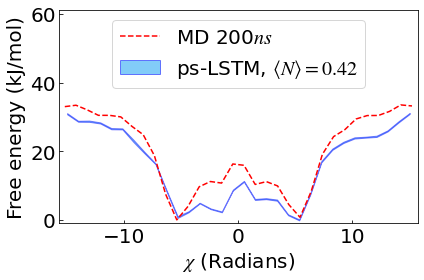

In [13]:
freeE2_arr = np.array(list(freeE2.values()))
mean_freeE2=np.mean(freeE2_arr, axis=0)
stdv_freeE2=np.std(freeE2_arr, axis=0)/np.sqrt(len(freeE2_arr))

fig, ax=plt.subplots(figsize=(6,4), nrows=1, ncols=1)

ax.plot(mids_200ns, freeE_200ns-np.min(freeE_200ns), linestyle='--', color='red', label='MD 200$ns$')
ax.fill_between(mids2-15.5, mean_freeE2-np.min(mean_freeE2)-stdv_freeE2, mean_freeE2-np.min(mean_freeE2)+stdv_freeE2, label='ps-LSTM, $\langle N\\rangle=0.42$',
                alpha=0.5, edgecolor='blue', facecolor='#069AF3')


ax.tick_params(axis='both', which='both', labelsize=20, direction='in')
ax.set_xlabel('$\chi$ (Radians)', size=20)
ax.set_ylabel('Free energy (kJ/mol)', size=20)
ax.set_xlim(-np.pi*5, np.pi*5)
ax.set_ylim(-1, 61)
ax.legend(loc='upper center', fontsize=20)

fig.tight_layout()
plt.savefig('training2_NN0_42.pdf', format='pdf', dpi=300, pad_inches = 0.05)
plt.show()

### compared with prediction by first training

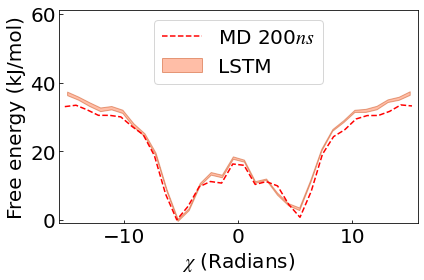

In [17]:
freeE1_arr = np.array(list(freeE1.values()))
mean_freeE1=np.mean(freeE1_arr, axis=0)
stdv_freeE1=np.std(freeE1_arr, axis=0)/np.sqrt(len(freeE1_arr))

fig, ax=plt.subplots(figsize=(6,4), nrows=1, ncols=1)

ax.plot(mids_200ns, freeE_200ns-np.min(freeE_200ns), linestyle='--', color='red', label='MD 200$ns$')

# ax.errorbar(mids1-16, mean_freeE1-np.min(mean_freeE1), yerr=stdv_freeE1, linestyle='--', color='coral', capsize=3, label='LSTM')
ax.fill_between(mids1-15.5, mean_freeE1-np.min(mean_freeE1)-stdv_freeE1, mean_freeE1-np.min(mean_freeE1)+stdv_freeE1, label='LSTM',
                alpha=0.5, edgecolor='#CC4F1B', facecolor='coral')


ax.tick_params(axis='both', which='both', labelsize=20, direction='in')
ax.set_xlabel('$\chi$ (Radians)', size=20)
ax.set_ylabel('Free energy (kJ/mol)', size=20)
ax.set_xlim(-np.pi*5, np.pi*5)
ax.set_ylim(-1, 61)
ax.legend(loc='upper center', fontsize=20)

fig.tight_layout()
plt.savefig('training1.pdf', format='pdf', dpi=300, pad_inches = 0.05)
plt.show()